# Introduction to Monte Carlo Simulation in Finance

## Example: A Crude Simulation of a Call Option Price under the Black-Scholes Model

Ref.: *Don L. McLeish* **Monte Carlo Simulation and Finance** Wiley

<img src="img/cover_mcleish.jpg" width="10%" align="left" border="0">

In [122]:
%matplotlib inline

import numpy as np
import scipy as sc

from math        import sqrt
from scipy.stats import norm as scnorm
from pylab       import *
from matplotlib  import pyplot as pl


It's worth to recast the pricing problem into a simple integral formulation in order to gain some insight into the general problem;
\item So let's consider again the payoff of a simple plain vanilla option
$$e^{-rT} \mathbb{E^Q} [ h(S_T) ] = e^{-rT} \mathbb{E^Q} \left[ h \left( S_0 e^{\log(S_T/S_0)} \right) \right]$$

By a simple application of Ito's lemma is easy to demonstrate that the variable $X = \log(S_T/S_0)$ has a normal distribution with mean $m=(r-\frac{1}{2} \sigma^2)T$ and variance $s=\sigma^2T$.

So we can write
$$ C(S,t)= e^{-rT}\int\limits_{-\infty}^{+\infty} \max[S_0e^X-K,0] e^{-\frac{(X-m)^2}{2s^2}} dX  $$

It is possible to generate a normally distributed random variable $X=\Phi^{-1}(U;(r-\frac{1}{2} \sigma^2)T;\sigma^2T)$ using the inverse transform method, where $\Phi^{-1}(U;(r-\frac{1}{2} \sigma^2)T;\sigma^2T)$ is the inverse of the normal cumulative distribution function evaluated at $U$, a uniform $[0,1]$ random variable.

$$U = \Phi[X;m,u], \quad u\rightarrow 1 \, when \, X \rightarrow +\infty, \quad u\rightarrow 0 \, when \, X \rightarrow -\infty$$

has a uniform distribution;

From the previous relation we find (within a normalization factor)

$$du = \frac{d\Phi[X;m,u]}{dX} dX  \Rightarrow dX = \frac{1}{e^{-\frac{(X-m)^2}{2s^2}}}du$$

Then the value of the option can be written as an expectation over the distribution of the uniform random variabile $U$:

$$
C(S,t) = \int\limits_0^1 f(u) du$$
where $f(u) = e^{-rT} \max[S_0 \exp(\Phi^{-1}(u; m,s)) - K,0] $

In [123]:
def f(u, S0, K, r, sigma, T):
    m      = (r - .5*sigma*sigma)*T
    s      = sigma*sqrt(T)
    f_u    = exp(-r*T)*np.maximum(S0*exp(scnorm.ppf(u, m, s))-K,0)
    return f_u
    #
    # this is the same code in R language
    #
    #x = S0*exp(qnorm(u,mean=r*T-sigma^2*T/2,sd=sigma*sqrt(T)))
    #v = exp(-r*T) * pmax((x-K),0)

where scnorm.ppf is the [inverse of cumulative normal](http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.stats.norm.html)

We recall the Black and Scholes formulas from the pricing of Call and Put Options...

$C(S(t)) = S(t)N(d_1)-Ke^{-r(T-t)}N(d_2)$

$P(S(t)) = Ke^{-r(T-t)}N(-d_2) - S(t)N(-d_1)$

where

$d_1=\frac{\log(S(t)/K)+(r+\sigma^2/2}{\sigma \sqrt{T}}$ 

$d_2 = d_1 - \sigma \sqrt{T}$

In [124]:
import numpy as np
import scipy.stats as ss
import time 

#Black and Scholes
def d1(S0, K, r, sigma, T):
    return (np.log(S0/float(K)) + (r + sigma**2 / 2.0) * T)/ float(sigma * np.sqrt(T))
 
def d2(S0, K, r, sigma, T):
    return (np.log(S0/float(K)) + (r - sigma**2 / 2.0) * T) / float(sigma * np.sqrt(T))
 
def BlackScholes(payoff, S0, K, r, sigma, T):
    if payoff == 1:
        return S0 * ss.norm.cdf(d1(S0, K, r, sigma, T)) - K * np.exp(-r * T) * ss.norm.cdf(d2(S0, K, r, sigma, T))
    else:
        return K * np.exp(-r * T) * ss.norm.cdf(-d2(S0, K, r, sigma, T)) - S0 * ss.norm.cdf(-d1(S0, K, r, sigma, T))


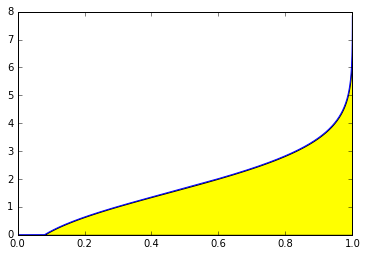

In [125]:
S0     = 10.5
K      = 8.75
r      = 0.005
T      = 0.25
sigma  = 0.25

u      = np.linspace(0, 1, 10000)
f_u    = f(u,S0,K,r,sigma,T)

pl.plot(u, f_u)
pl.fill_between(u, f_u, facecolor='yellow', interpolate=True)
pl.show()


In [126]:
u      = rand(10000000)
f_u    = f(u,S0,K,r,sigma,T)
mc     = mean(f_u)
bs     = BlackScholes(1,S0,K,r,sigma, T)
delta  = abs(mc-bs)

print 'Montecarlo estimate : %f'%mc
print 'Analytical result   : %f'%bs
print 'Difference          : %f'%delta

Montecarlo estimate : 1.798576
Analytical result   : 1.798561
Difference          : 0.000015
